<a href="https://colab.research.google.com/github/krishnamanc/PytorchPractice/blob/main/Cat_Dog_Classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 94% 205M/218M [00:01<00:00, 138MB/s]
100% 218M/218M [00:01<00:00, 116MB/s]


In [ ]:
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [ ]:
! pip install torchinfo

In [ ]:
# Codeblock 1
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader

In [ ]:
# Codeblock 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Codeblock 3
def load_images(path):

    images = []
    filenames = os.listdir(path)

    for filename in tqdm(filenames):
        if filename == '_DS_Store':
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(100,100))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

    return np.array(images)

In [ ]:
# Codeblock 4
cats_train = load_images('/content/training_set/training_set/cats')
dogs_train = load_images('/content/training_set/training_set/dogs')

cats_test = load_images('/content/test_set/test_set/cats')
dogs_test = load_images('/content/test_set/test_set/dogs')

100%|██████████| 1013/1013 [00:01<00:00, 541.12it/s]


In [ ]:
# Codeblock 5
print(cats_train.shape)
print(dogs_train.shape)
print(cats_test.shape)
print(dogs_test.shape)

(4000, 100, 100, 3)
(4005, 100, 100, 3)
(1011, 100, 100, 3)
(1012, 100, 100, 3)


In [ ]:
# Codeblock 6
X_train = np.append(cats_train, dogs_train, axis=0)
X_test  = np.append(cats_test, dogs_test, axis=0)

print(X_train.shape)
print(X_test.shape)

(8005, 100, 100, 3)
(2023, 100, 100, 3)


In [ ]:
# Codeblock 7
y_train = np.array([0] * len(cats_train) + [1] * len(dogs_train))
y_test = np.array([0] * len(cats_test) + [1] * len(dogs_test))

print(y_train.shape)
print(y_test.shape)

(8005,)
(2023,)


In [ ]:
# Codeblock 8
def show_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i,j].set_title(labels[counter].item())
            axes[i,j].imshow(images[counter], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

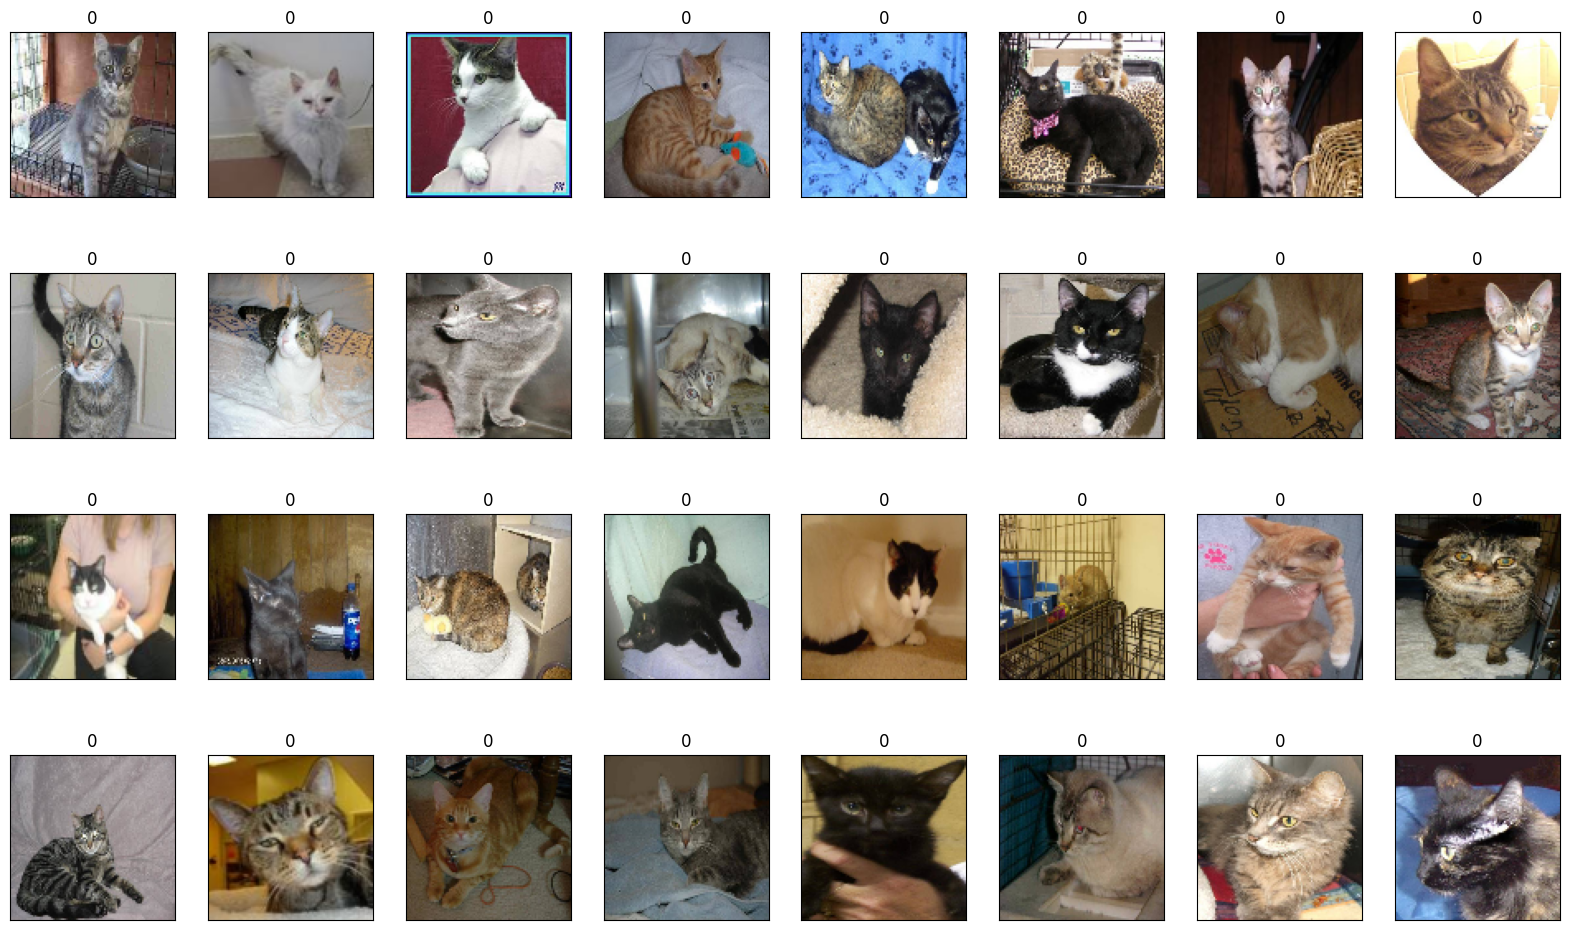

In [ ]:
# Codeblock 9
show_images(X_train, y_train, 0)

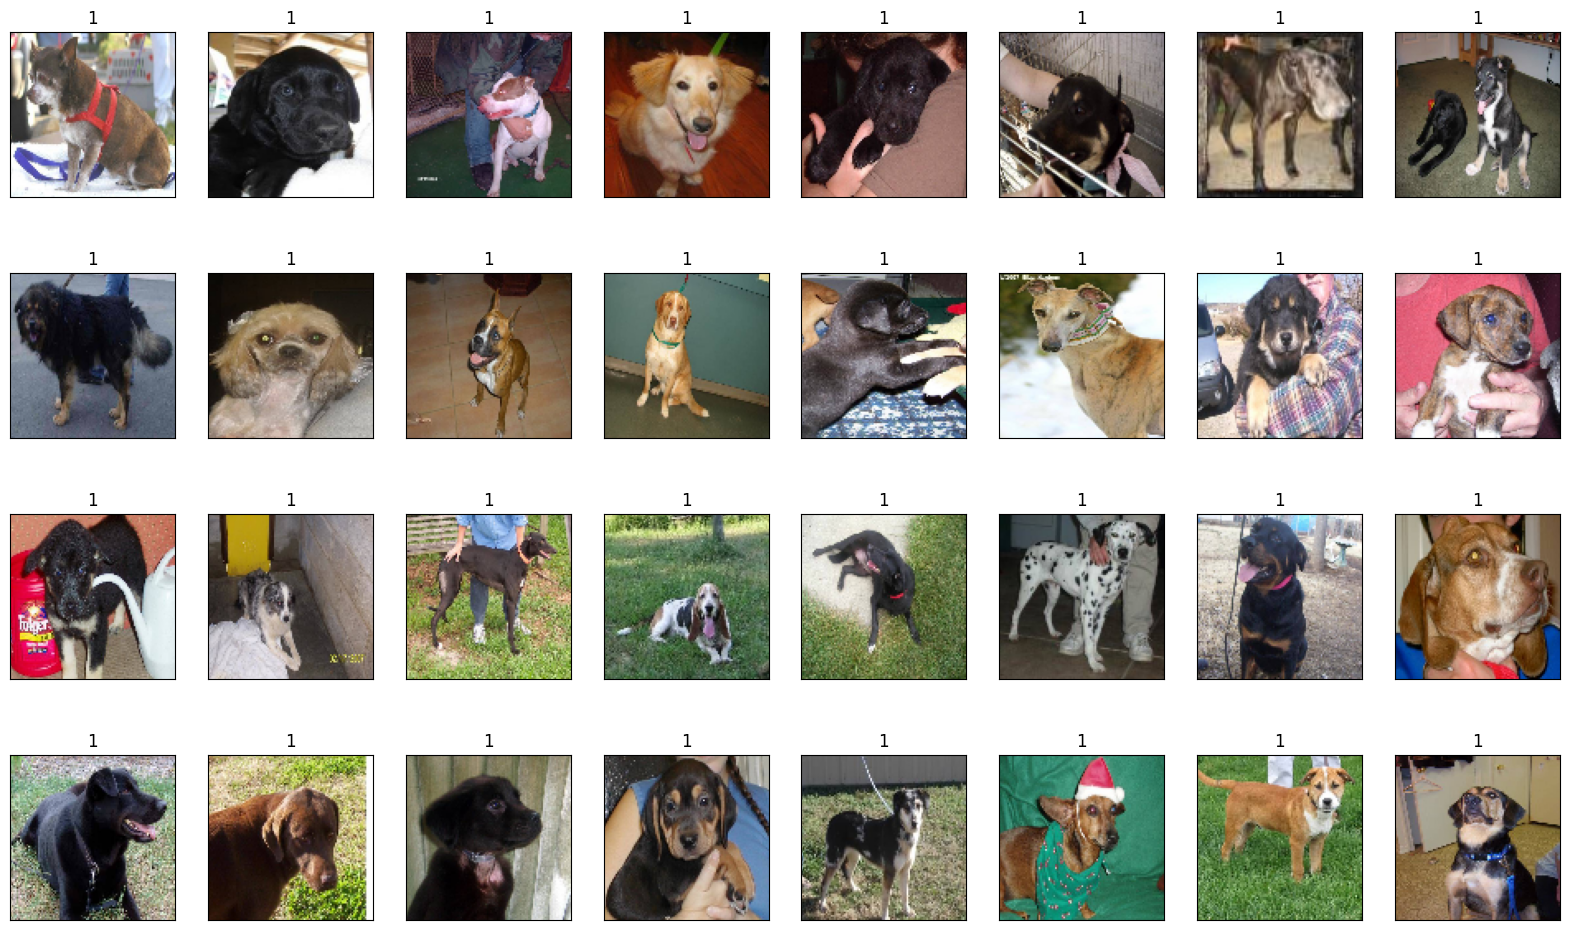

In [ ]:
# Codeblock 10
show_images(X_train, y_train, 4000)

In [ ]:
# Codeblock 11
print(y_train[:10])

[0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Codeblock 12
y_train = torch.from_numpy(y_train.reshape(len(y_train),1))
y_test = torch.from_numpy(y_test.reshape(len(y_test),1))

print(y_train[:10])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [ ]:
# Codeblock 13
transforms_train = transforms.Compose([transforms.ToTensor(), # convert to tensor
                                       transforms.RandomRotation(degrees=20),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.005),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [ ]:
# Codeblock 14
transforms_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [ ]:
# Codeblock 15
class Cat_Dog_Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [ ]:
# Codeblock 16
train_dataset = Cat_Dog_Dataset(images=X_train, labels=y_train, transform=transforms_train)
test_dataset  = Cat_Dog_Dataset(images=X_test, labels=y_test, transform=transforms_test)

In [ ]:
# Codeblock 17
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [ ]:
# Codeblock 18
iterator = iter(train_loader)
image_batch, label_batch = next(iterator)

print(image_batch.shape)

torch.Size([32, 3, 100, 100])


torch.Size([32, 100, 100, 3])


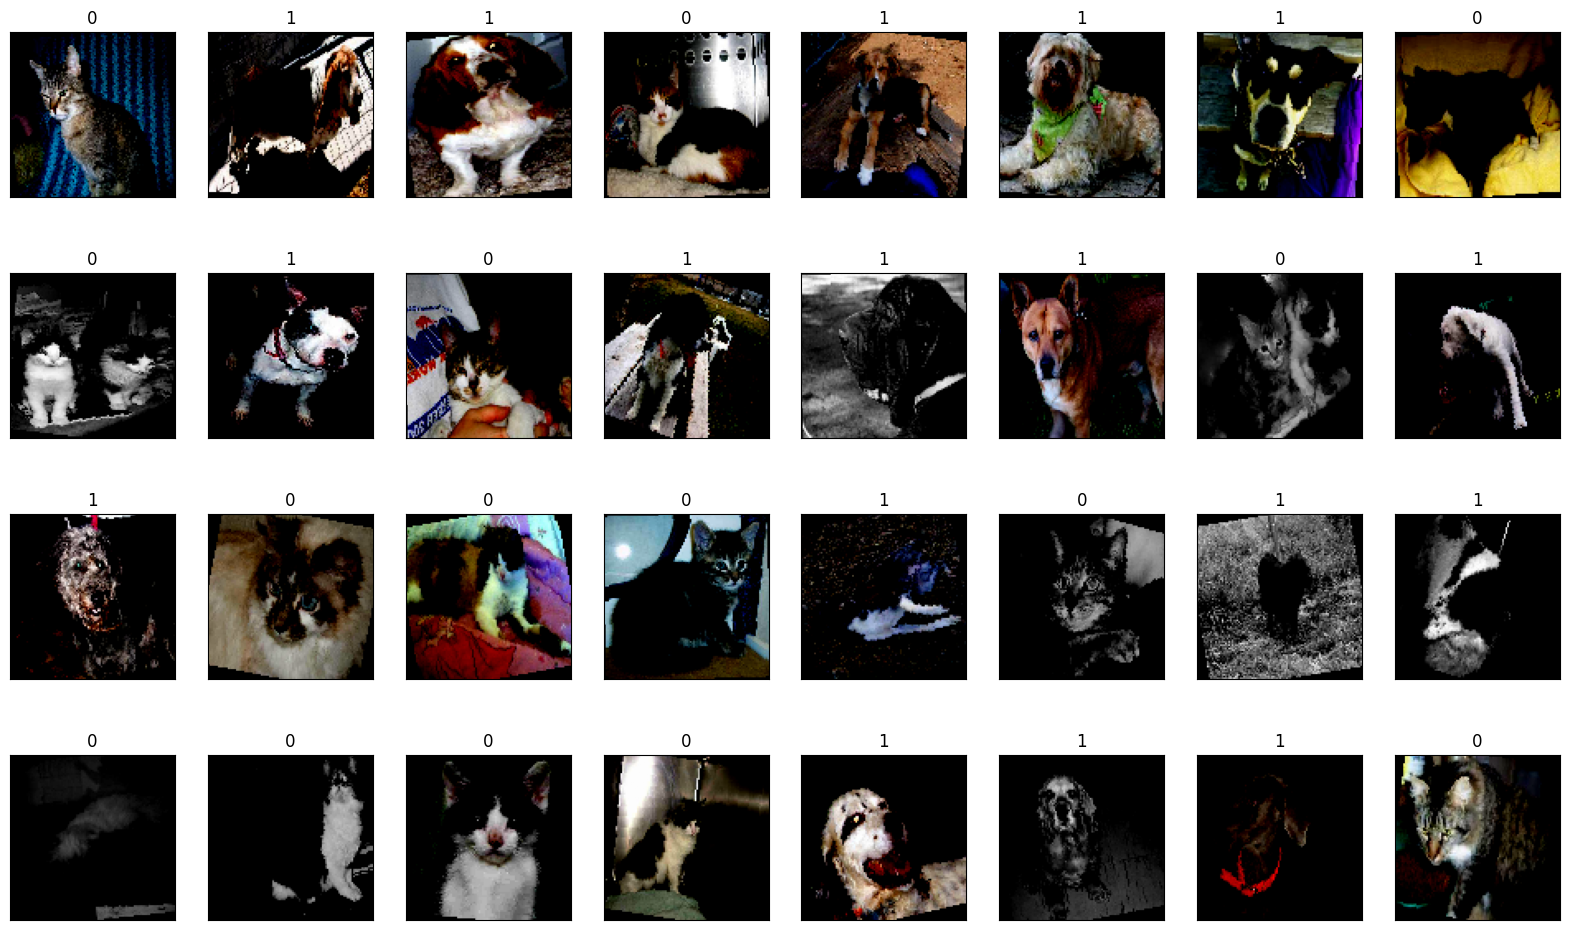

In [ ]:
# Codeblock 19
image_batch_permuted = image_batch.permute(0, 2, 3, 1)

print(image_batch_permuted.shape)

show_images(image_batch_permuted, label_batch, 0)

In [ ]:
# Codeblock 20
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn0 = nn.BatchNorm2d(num_features=16)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        # self.maxpool

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        # self.maxpool

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        # self.maxpool

        self.dropout = nn.Dropout(p=0.5)
        self.fc0 = nn.Linear(in_features=128*6*6, out_features=64)
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = F.relu(self.bn0(self.conv0(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = x.reshape(x.shape[0], -1)

        x = self.dropout(x)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))

        return x

In [ ]:
# Codeblock 21
model = CNN().to(device)

In [ ]:
# Codeblock 22
summary(model, input_size=(4,3,100,100))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [4, 1]                    --
├─Conv2d: 1-1                            [4, 16, 100, 100]         432
├─BatchNorm2d: 1-2                       [4, 16, 100, 100]         32
├─MaxPool2d: 1-3                         [4, 16, 50, 50]           --
├─Conv2d: 1-4                            [4, 32, 50, 50]           4,608
├─BatchNorm2d: 1-5                       [4, 32, 50, 50]           64
├─MaxPool2d: 1-6                         [4, 32, 25, 25]           --
├─Conv2d: 1-7                            [4, 64, 25, 25]           18,432
├─BatchNorm2d: 1-8                       [4, 64, 25, 25]           128
├─MaxPool2d: 1-9                         [4, 64, 12, 12]           --
├─Conv2d: 1-10                           [4, 128, 12, 12]          73,728
├─BatchNorm2d: 1-11                      [4, 128, 12, 12]          256
├─MaxPool2d: 1-12                        [4, 128, 6, 6]            --
├

In [ ]:
# Codeblock 23
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Codeblock 24
def predict_test_data(model, test_loader):

    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float().to(device)
            y_test = y_test.float().to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)

            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)

    model.train()

    test_acc = num_correct/num_samples

    return test_loss, test_acc

In [ ]:
# Codeblock 25

train_losses = []    # Training and testing loss was calculated based on the last batch of each epoch.
test_losses  = []
train_accs = []
test_accs  = []

for epoch in range(100):

    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)

        # Forward propagation
        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)

        # Calculate train accuracy
        with torch.no_grad():
            rounded_train_preds = torch.round(train_preds)
            num_correct_train += torch.sum(rounded_train_preds == y_train)
            num_samples_train += len(y_train)

        # Backward propagation
        optimizer.zero_grad()
        train_loss.backward()

        # Gradient descent
        optimizer.step()

    train_acc = num_correct_train/num_samples_train
    test_loss, test_acc = predict_test_data(model, test_loader)

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())

    print(f'Epoch: {epoch} \t|' \
            f' Train loss: {np.round(train_loss.item(),3)} \t|' \
            f' Test loss: {np.round(test_loss.item(),3)} \t|' \
            f' Train acc: {np.round(train_acc.item(),2)} \t|' \
            f' Test acc: {np.round(test_acc.item(),2)}')

100%|██████████| 250/250 [00:12<00:00, 20.64it/s]


Epoch: 0 	| Train loss: 0.497 	| Test loss: 0.618 	| Train acc: 0.66 	| Test acc: 0.71


100%|██████████| 250/250 [00:10<00:00, 23.47it/s]


Epoch: 1 	| Train loss: 0.419 	| Test loss: 0.566 	| Train acc: 0.73 	| Test acc: 0.75


100%|██████████| 250/250 [00:11<00:00, 22.52it/s]


Epoch: 2 	| Train loss: 0.536 	| Test loss: 0.287 	| Train acc: 0.77 	| Test acc: 0.8


100%|██████████| 250/250 [00:10<00:00, 23.25it/s]


Epoch: 3 	| Train loss: 0.462 	| Test loss: 0.594 	| Train acc: 0.79 	| Test acc: 0.79


100%|██████████| 250/250 [00:11<00:00, 22.66it/s]


Epoch: 4 	| Train loss: 0.29 	| Test loss: 0.455 	| Train acc: 0.81 	| Test acc: 0.82


100%|██████████| 250/250 [00:11<00:00, 22.17it/s]


Epoch: 5 	| Train loss: 0.403 	| Test loss: 0.375 	| Train acc: 0.82 	| Test acc: 0.84


100%|██████████| 250/250 [00:11<00:00, 22.49it/s]


Epoch: 6 	| Train loss: 0.405 	| Test loss: 0.462 	| Train acc: 0.83 	| Test acc: 0.84


100%|██████████| 250/250 [00:11<00:00, 21.96it/s]


Epoch: 7 	| Train loss: 0.283 	| Test loss: 0.164 	| Train acc: 0.84 	| Test acc: 0.85


100%|██████████| 250/250 [00:11<00:00, 21.90it/s]


Epoch: 8 	| Train loss: 0.382 	| Test loss: 0.313 	| Train acc: 0.84 	| Test acc: 0.86


100%|██████████| 250/250 [00:11<00:00, 21.94it/s]


Epoch: 9 	| Train loss: 0.138 	| Test loss: 0.696 	| Train acc: 0.85 	| Test acc: 0.77


100%|██████████| 250/250 [00:11<00:00, 22.15it/s]


Epoch: 10 	| Train loss: 0.112 	| Test loss: 0.121 	| Train acc: 0.86 	| Test acc: 0.87


100%|██████████| 250/250 [00:11<00:00, 21.89it/s]


Epoch: 11 	| Train loss: 0.357 	| Test loss: 0.133 	| Train acc: 0.86 	| Test acc: 0.88


100%|██████████| 250/250 [00:11<00:00, 22.05it/s]


Epoch: 12 	| Train loss: 0.282 	| Test loss: 0.424 	| Train acc: 0.87 	| Test acc: 0.86


100%|██████████| 250/250 [00:11<00:00, 22.06it/s]


Epoch: 13 	| Train loss: 0.25 	| Test loss: 0.215 	| Train acc: 0.88 	| Test acc: 0.85


100%|██████████| 250/250 [00:11<00:00, 21.80it/s]


Epoch: 14 	| Train loss: 0.205 	| Test loss: 0.382 	| Train acc: 0.88 	| Test acc: 0.88


100%|██████████| 250/250 [00:11<00:00, 22.27it/s]


Epoch: 15 	| Train loss: 0.188 	| Test loss: 0.17 	| Train acc: 0.89 	| Test acc: 0.88


100%|██████████| 250/250 [00:11<00:00, 22.41it/s]


Epoch: 16 	| Train loss: 0.267 	| Test loss: 0.582 	| Train acc: 0.88 	| Test acc: 0.79


100%|██████████| 250/250 [00:11<00:00, 22.32it/s]


Epoch: 17 	| Train loss: 0.288 	| Test loss: 0.304 	| Train acc: 0.89 	| Test acc: 0.89


100%|██████████| 250/250 [00:11<00:00, 21.86it/s]


Epoch: 18 	| Train loss: 0.123 	| Test loss: 0.183 	| Train acc: 0.89 	| Test acc: 0.87


100%|██████████| 250/250 [00:11<00:00, 22.17it/s]


Epoch: 19 	| Train loss: 0.143 	| Test loss: 0.249 	| Train acc: 0.9 	| Test acc: 0.89


100%|██████████| 250/250 [00:10<00:00, 22.81it/s]


Epoch: 20 	| Train loss: 0.237 	| Test loss: 0.475 	| Train acc: 0.89 	| Test acc: 0.86


100%|██████████| 250/250 [00:10<00:00, 22.84it/s]


Epoch: 21 	| Train loss: 0.448 	| Test loss: 0.088 	| Train acc: 0.9 	| Test acc: 0.88


100%|██████████| 250/250 [00:11<00:00, 22.71it/s]


Epoch: 22 	| Train loss: 0.166 	| Test loss: 0.335 	| Train acc: 0.9 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.18it/s]


Epoch: 23 	| Train loss: 0.168 	| Test loss: 0.268 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 21.20it/s]


Epoch: 24 	| Train loss: 0.254 	| Test loss: 0.388 	| Train acc: 0.91 	| Test acc: 0.84


100%|██████████| 250/250 [00:11<00:00, 21.99it/s]


Epoch: 25 	| Train loss: 0.313 	| Test loss: 0.223 	| Train acc: 0.91 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 21.83it/s]


Epoch: 26 	| Train loss: 0.252 	| Test loss: 0.22 	| Train acc: 0.91 	| Test acc: 0.87


100%|██████████| 250/250 [00:11<00:00, 22.00it/s]


Epoch: 27 	| Train loss: 0.314 	| Test loss: 0.192 	| Train acc: 0.92 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 21.81it/s]


Epoch: 28 	| Train loss: 0.192 	| Test loss: 0.188 	| Train acc: 0.91 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 21.82it/s]


Epoch: 29 	| Train loss: 0.137 	| Test loss: 0.458 	| Train acc: 0.92 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 21.78it/s]


Epoch: 30 	| Train loss: 0.287 	| Test loss: 0.282 	| Train acc: 0.92 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 21.76it/s]


Epoch: 31 	| Train loss: 0.195 	| Test loss: 0.236 	| Train acc: 0.92 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.12it/s]


Epoch: 32 	| Train loss: 0.328 	| Test loss: 0.362 	| Train acc: 0.92 	| Test acc: 0.88


100%|██████████| 250/250 [00:11<00:00, 21.98it/s]


Epoch: 33 	| Train loss: 0.153 	| Test loss: 0.151 	| Train acc: 0.92 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.39it/s]


Epoch: 34 	| Train loss: 0.257 	| Test loss: 0.104 	| Train acc: 0.92 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 22.81it/s]


Epoch: 35 	| Train loss: 0.176 	| Test loss: 0.334 	| Train acc: 0.92 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.33it/s]


Epoch: 36 	| Train loss: 0.117 	| Test loss: 0.104 	| Train acc: 0.93 	| Test acc: 0.9


100%|██████████| 250/250 [00:11<00:00, 22.26it/s]


Epoch: 37 	| Train loss: 0.264 	| Test loss: 0.085 	| Train acc: 0.93 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 21.69it/s]


Epoch: 38 	| Train loss: 0.186 	| Test loss: 0.223 	| Train acc: 0.93 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.24it/s]


Epoch: 39 	| Train loss: 0.15 	| Test loss: 0.174 	| Train acc: 0.93 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.42it/s]


Epoch: 40 	| Train loss: 0.115 	| Test loss: 0.033 	| Train acc: 0.93 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.59it/s]


Epoch: 41 	| Train loss: 0.102 	| Test loss: 0.204 	| Train acc: 0.93 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.11it/s]


Epoch: 42 	| Train loss: 0.083 	| Test loss: 0.305 	| Train acc: 0.93 	| Test acc: 0.91


100%|██████████| 250/250 [00:10<00:00, 22.76it/s]


Epoch: 43 	| Train loss: 0.17 	| Test loss: 0.369 	| Train acc: 0.93 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 21.81it/s]


Epoch: 44 	| Train loss: 0.371 	| Test loss: 0.151 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.04it/s]


Epoch: 45 	| Train loss: 0.166 	| Test loss: 0.11 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.05it/s]


Epoch: 46 	| Train loss: 0.207 	| Test loss: 0.167 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.69it/s]


Epoch: 47 	| Train loss: 0.044 	| Test loss: 0.28 	| Train acc: 0.94 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.07it/s]


Epoch: 48 	| Train loss: 0.134 	| Test loss: 0.032 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.30it/s]


Epoch: 49 	| Train loss: 0.118 	| Test loss: 0.163 	| Train acc: 0.94 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 21.88it/s]


Epoch: 50 	| Train loss: 0.063 	| Test loss: 3.176 	| Train acc: 0.94 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.27it/s]


Epoch: 51 	| Train loss: 0.203 	| Test loss: 0.122 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.46it/s]


Epoch: 52 	| Train loss: 0.036 	| Test loss: 0.265 	| Train acc: 0.94 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.35it/s]


Epoch: 53 	| Train loss: 0.201 	| Test loss: 0.258 	| Train acc: 0.94 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.19it/s]


Epoch: 54 	| Train loss: 0.142 	| Test loss: 0.307 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.18it/s]


Epoch: 55 	| Train loss: 0.199 	| Test loss: 0.189 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.36it/s]


Epoch: 56 	| Train loss: 0.13 	| Test loss: 0.356 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 22.93it/s]


Epoch: 57 	| Train loss: 0.168 	| Test loss: 0.112 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.70it/s]


Epoch: 58 	| Train loss: 0.075 	| Test loss: 0.202 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.16it/s]


Epoch: 59 	| Train loss: 0.281 	| Test loss: 0.149 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 21.87it/s]


Epoch: 60 	| Train loss: 0.065 	| Test loss: 0.209 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.11it/s]


Epoch: 61 	| Train loss: 0.066 	| Test loss: 0.082 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 21.96it/s]


Epoch: 62 	| Train loss: 0.074 	| Test loss: 0.125 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.35it/s]


Epoch: 63 	| Train loss: 0.092 	| Test loss: 0.286 	| Train acc: 0.95 	| Test acc: 0.91


100%|██████████| 250/250 [00:11<00:00, 22.72it/s]


Epoch: 64 	| Train loss: 0.174 	| Test loss: 0.133 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.13it/s]


Epoch: 65 	| Train loss: 0.104 	| Test loss: 0.125 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.36it/s]


Epoch: 66 	| Train loss: 0.042 	| Test loss: 0.106 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 21.91it/s]


Epoch: 67 	| Train loss: 0.027 	| Test loss: 0.19 	| Train acc: 0.95 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.15it/s]


Epoch: 68 	| Train loss: 0.039 	| Test loss: 0.213 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.58it/s]


Epoch: 69 	| Train loss: 0.136 	| Test loss: 0.49 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.13it/s]


Epoch: 70 	| Train loss: 0.086 	| Test loss: 0.037 	| Train acc: 0.95 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.56it/s]


Epoch: 71 	| Train loss: 0.091 	| Test loss: 0.115 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.32it/s]


Epoch: 72 	| Train loss: 0.161 	| Test loss: 0.068 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 22.82it/s]


Epoch: 73 	| Train loss: 0.084 	| Test loss: 0.208 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 22.91it/s]


Epoch: 74 	| Train loss: 0.029 	| Test loss: 0.164 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.00it/s]


Epoch: 75 	| Train loss: 0.118 	| Test loss: 0.706 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.40it/s]


Epoch: 76 	| Train loss: 0.206 	| Test loss: 0.03 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.19it/s]


Epoch: 77 	| Train loss: 0.052 	| Test loss: 0.444 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.43it/s]


Epoch: 78 	| Train loss: 0.052 	| Test loss: 0.093 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.29it/s]


Epoch: 79 	| Train loss: 0.042 	| Test loss: 0.09 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 21.99it/s]


Epoch: 80 	| Train loss: 0.121 	| Test loss: 0.311 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.09it/s]


Epoch: 81 	| Train loss: 0.212 	| Test loss: 0.023 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.61it/s]


Epoch: 82 	| Train loss: 0.065 	| Test loss: 0.136 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 22.63it/s]


Epoch: 83 	| Train loss: 0.053 	| Test loss: 0.19 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.40it/s]


Epoch: 84 	| Train loss: 0.034 	| Test loss: 0.174 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.26it/s]


Epoch: 85 	| Train loss: 0.048 	| Test loss: 0.609 	| Train acc: 0.97 	| Test acc: 0.94


100%|██████████| 250/250 [00:11<00:00, 22.37it/s]


Epoch: 86 	| Train loss: 0.056 	| Test loss: 0.326 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.31it/s]


Epoch: 87 	| Train loss: 0.06 	| Test loss: 0.205 	| Train acc: 0.96 	| Test acc: 0.94


100%|██████████| 250/250 [00:11<00:00, 22.34it/s]


Epoch: 88 	| Train loss: 0.023 	| Test loss: 0.162 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.24it/s]


Epoch: 89 	| Train loss: 0.024 	| Test loss: 0.302 	| Train acc: 0.97 	| Test acc: 0.92


100%|██████████| 250/250 [00:10<00:00, 23.10it/s]


Epoch: 90 	| Train loss: 0.183 	| Test loss: 0.139 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:10<00:00, 23.25it/s]


Epoch: 91 	| Train loss: 0.17 	| Test loss: 0.055 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.51it/s]


Epoch: 92 	| Train loss: 0.067 	| Test loss: 0.046 	| Train acc: 0.96 	| Test acc: 0.92


100%|██████████| 250/250 [00:11<00:00, 21.96it/s]


Epoch: 93 	| Train loss: 0.066 	| Test loss: 0.083 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.41it/s]


Epoch: 94 	| Train loss: 0.108 	| Test loss: 0.352 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.44it/s]


Epoch: 95 	| Train loss: 0.045 	| Test loss: 0.099 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.20it/s]


Epoch: 96 	| Train loss: 0.014 	| Test loss: 0.17 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.28it/s]


Epoch: 97 	| Train loss: 0.035 	| Test loss: 0.155 	| Train acc: 0.96 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 21.84it/s]


Epoch: 98 	| Train loss: 0.038 	| Test loss: 0.044 	| Train acc: 0.97 	| Test acc: 0.93


100%|██████████| 250/250 [00:11<00:00, 22.06it/s]


Epoch: 99 	| Train loss: 0.016 	| Test loss: 0.114 	| Train acc: 0.97 	| Test acc: 0.93


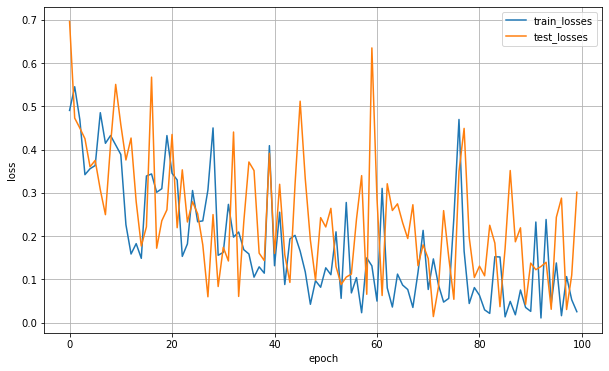

In [ ]:
# Codeblock 26
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses', 'test_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
torch.save(model, 'catdog1.pth')

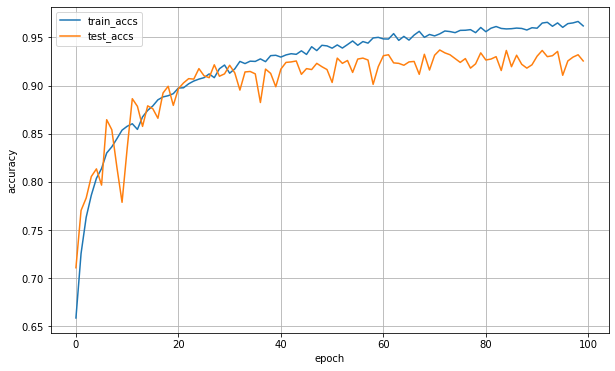

In [ ]:
# Codeblock 27
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs', 'test_accs'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

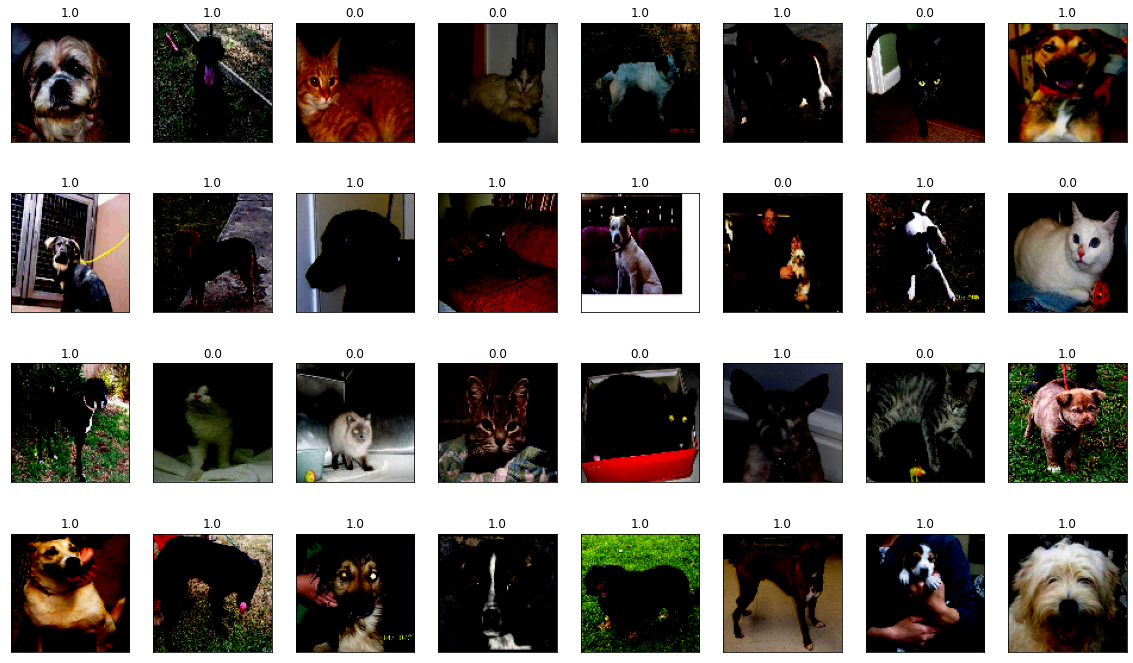

In [ ]:
# Codeblock 28

# Load test images
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

# Predict labels
preds_test = model(img_test.to(device))
img_test_permuted = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.round()

# Show test images and the predicted labels
show_images(img_test_permuted, rounded_preds, 0)